# Hsp70 protein Notebook
The Hsp70 protein is chaperone protein; they can assist folding and assembly of newly synthesized proteins, trigger refolding cycles of misfolded proteins, transport unfolded proteins through organelle membranes, and when necessary, deliver non-functional proteins to the proteasome, endosome or lysosome for recycling.
Hsp70 genes differ by organism, location of expression (Nucleus/Cytoplasm, Mitochondria, ER, Chloroplasta), mode of expression (stress-induced or constitutive), substrate specificity (Target regular proteins or Iron-Sulfur cluster proteins,...). Here, RBM are used to highlight automatically the main differences between the subfamilies.



# Loading data and packages

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../source/')
sys.path.append('../utilities/')
from common_imports import set_num_threads
set_num_threads(8) # Set the number of cores. Must be executed before importing numpy&numba.
import numpy as np
import pickle
import rbm,utilities
import pandas as pd
import Proteins_utils, RBM_utils, utilities,sequence_logo,plots_utils


filename = 'Hsp70_protein_MSA.fasta'
path = u'../data/Hsp70/'

all_data, all_labels = Proteins_utils.load_FASTA(path+filename, with_labels = True)

env = pickle.load(open(path+'Hsp70_info.data','rb'),encoding='latin1')
for key,item in env.items():
    globals()[key] = item
    
print('First sequence of the alignment:')
print(Proteins_utils.num2seq(all_data[0]))


print('First sequence of the alignment (numerical format)')
print(all_data[0])


    

In [2]:
all_data.shape[in_train]

TypeError: only integer scalar arrays can be converted to a scalar index

# Training

In [ ]:
n_v = 675 # Number of visible units; = # sites in alignment.
n_h = 200 # Number of hidden units.
visible = 'Potts' # Nature of visible units potential. Here, Potts states...
n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.

RBM = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv)
batch_size = 100 # Size of mini-batches (and number of Markov chains used). Default: 100. Value for RBM shown in paper: 300
n_iter = 200 # Number of epochs.
learning_rate = 5e-3 # Initial learning rate (default: 5e-3).
decay_after = 0.5 # Decay learning rate after 33% of iterations (default: 0.5). Value for RBM shown in paper: 0.33
l1b = 0.8 # L1b regularization. Default : 0. Value for RBM shown in paper: 0.8
N_MC = 1 # Number of Monte Carlo steps between each update. Value for RBM shown in paper: 1

RBM.fit(all_data[in_train][order_train], weights= all_weights[in_train][order_train], batch_size = batch_size,
    n_iter = n_iter, l1b = l1b, N_MC = N_MC, 
   decay_after = decay_after, verbose = 0,vverbose=1 )


Starting epoch 1
Starting epoch 2
Starting epoch 3


In [55]:
DeltaL = RBM_utils.get_hidden_unit_importance(RBM,all_data,weights=all_weights)
RBM_utils.saveRBM('RBM_Hsp70.data',RBM)

../source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


Mismatch dimensions (100, 200), [200, 200], reinitializating I
Mismatch dimensions (100, 675, 21), [200, 675, 21], reinitializating I


../source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


Number of sites selected: 90


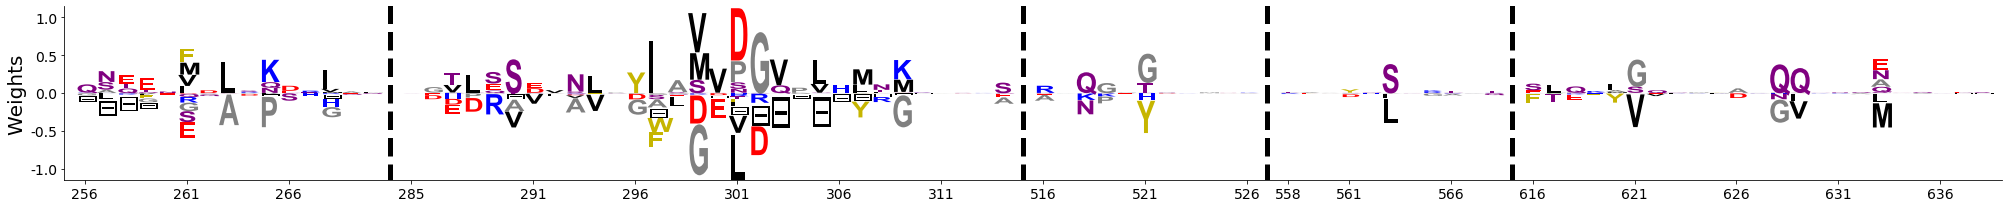

Number of sites selected: 27


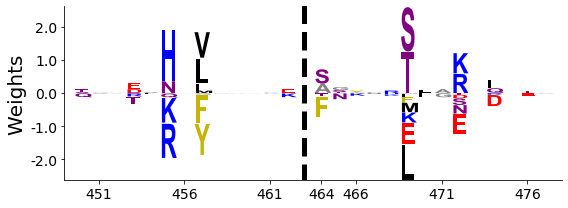

Number of sites selected: 178


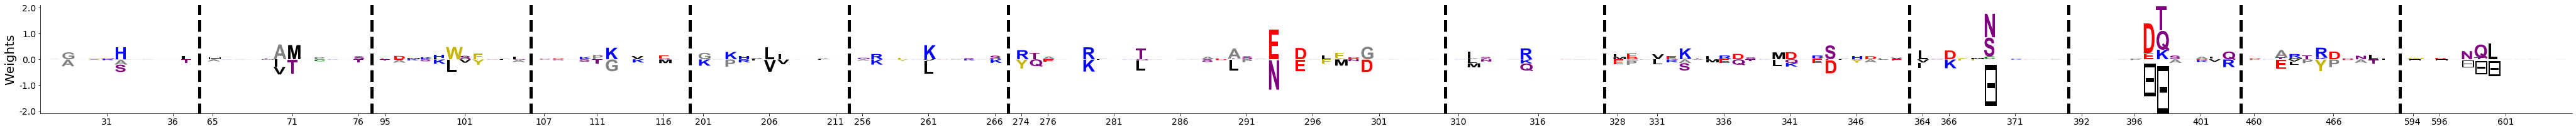

Number of sites selected: 104


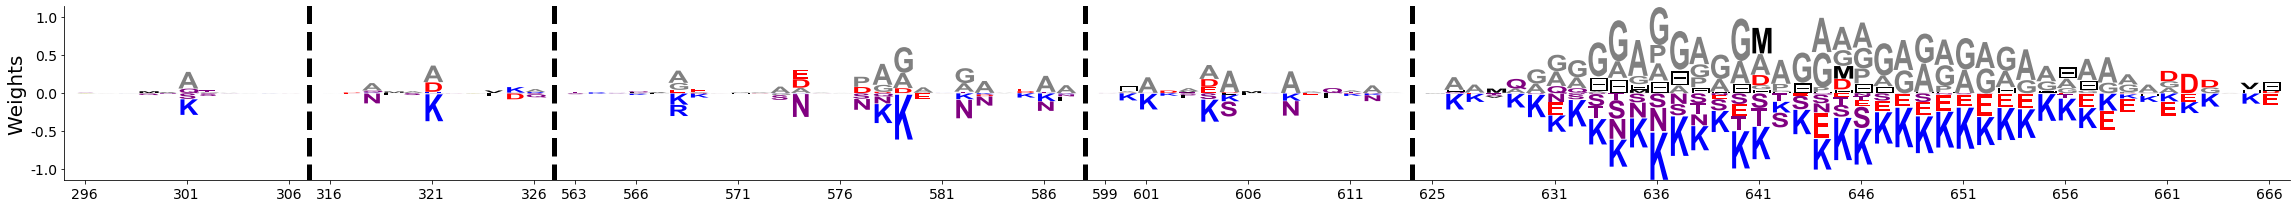

In [53]:
h = RBM.mean_hiddens(all_data)
first_target = (1 * is_dnak  + 1. * is_mitochondrial + 1. * is_chloroplastal- 1. * is_hsca - 1. * is_ER - 1. * is_nucleus_cyto)
second_target = (1 * is_hsca  + 1. * is_chloroplastal - 1. * is_non_allosteric - 1. * is_nucleus_cyto- 1. * is_ER)
third_target = 2*is_non_allosteric-1
fourth_target = 2*is_hsca-1
fifth_target = 2 * is_ER -1



interesting_features = np.zeros(10,dtype=np.int)
interesting_features = []

for target,index in [first_target,second_target,third_target,fourth_target,fifth_target],[0,1,3,5,7]:
    correlation = np.corrcoef(h[target!=0].T, target[np.newaxis,target!=0])[:-1,-1]
    i = np.argsort(np.abs(correlation))[-1]
    interesting_features[index]  = i
    
norm_site = np.abs(RBM.weights[:,:,:-1]).sum(-1)/np.abs(RBM.weights).sum(-1).sum(-1)[:,np.newaxis]
tail_norm = norm_site[:,625:].sum(1)
interesting_features[4] =  np.argmax(tail_norm)

import importlib;importlib.reload(sequence_logo)
sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[0]],theta_important=0.33);
sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[1]],theta_important=0.33);
sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[3]],theta_important=0.2);
sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[4]],theta_important=0.25);    
sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[5]],theta_important=0.25);    
sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[7]],theta_important=0.25);    

## Visualizing hidden units: Sequence logo of weights
Show sequence logos of some selected weights. Here, features reflect the structural constraint, as well as phylogenic diversity.


- Feature 1: Short loop on the NBD, discriminating between Prokaryotic DnaK and Eukaryotic Mitochondrial/Chloroplastal Hsp70 from Prokaryotic HSc.A and other Eukaryotic Hsp70. Linked to ATP exchange rate and  NEF co-chaperone specificity.
- Feature 2: A short motif on the beta strand of the SBD, putatively linked to substrate specificity.
- Feature 3: An interdomain feature, at the interface between the LID and SBD domains.
- Feature 4: An interdomain feature, at the interface between the NBD and SBD domains. Discriminates non-allosteric Hsp70 (aka Hsp110) from the others.
- Feature 5: A feature localized on the unstructured tail of the protein. Putatively linked to DnaJ co-chaperone specificity.
- Feature 6: Very Short loop on the NBD, discriminating between Prokaryotic HScA and the rest. Linked to ATP exchange rate and  NEF co-chaperone specificity.
- Feature 7: A variant of the NBD loop for Prokaryotic DNaKs. Putatively linked to NEF specificity.
- Feature 8: An interdomain feature discriminating Eukaryotic Hsp70 expressed in Endoplasmic Reticulum from the rest.
- Feature 9: Another interdomain feature discriminating non-allosteric Hsp70 from the others.
- Feature 10: A 'Dimeric' feature, whose important sites are separated in the ATP/ADP conformation, but close in the dimer.


Number of sites selected: 38


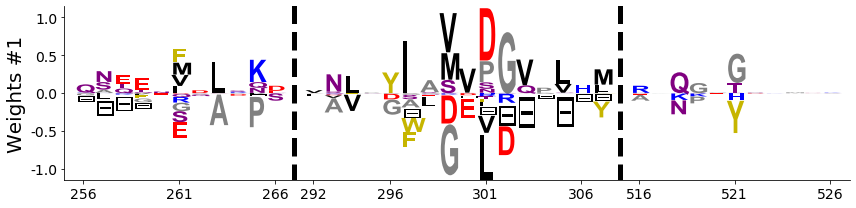

Number of sites selected: 25


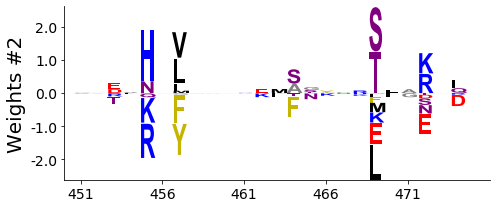

Number of sites selected: 198


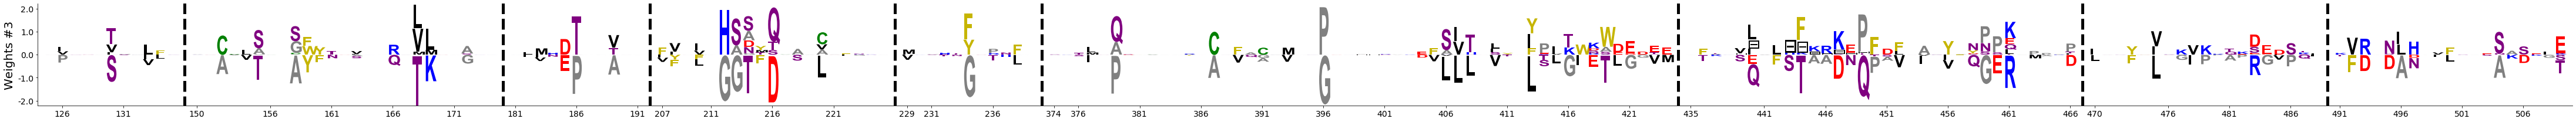

Number of sites selected: 34


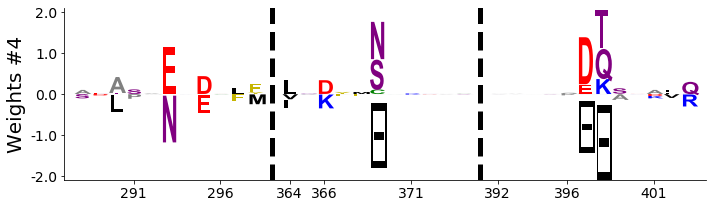

Number of sites selected: 49


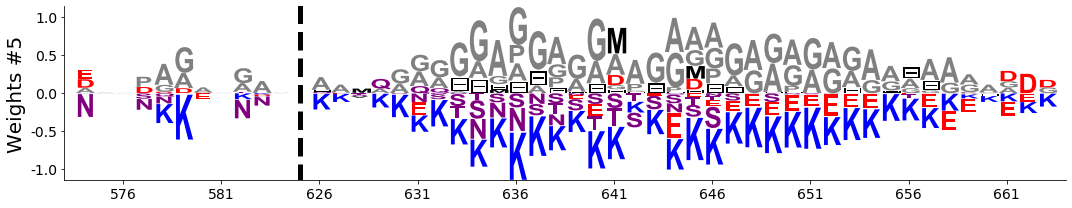

Number of sites selected: 154


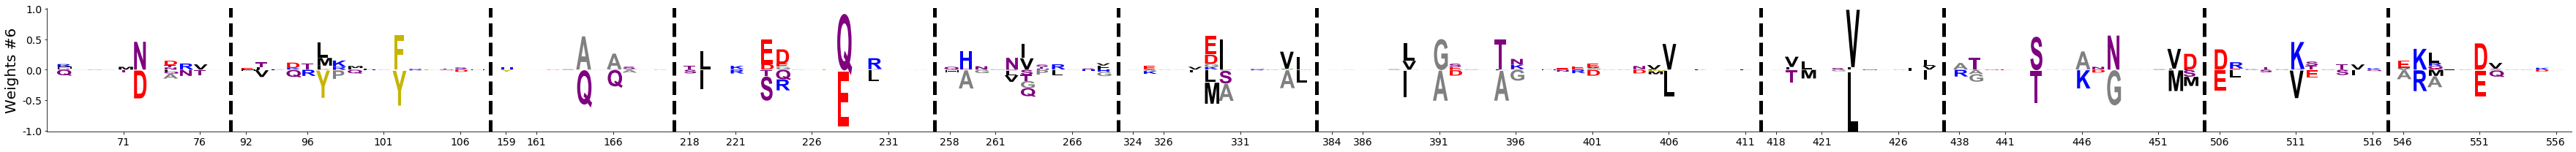

Number of sites selected: 11


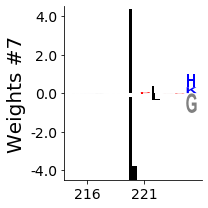

Number of sites selected: 208


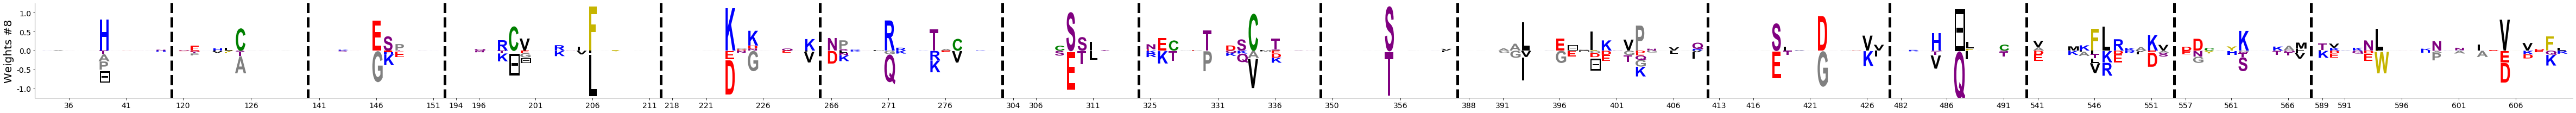

Number of sites selected: 46


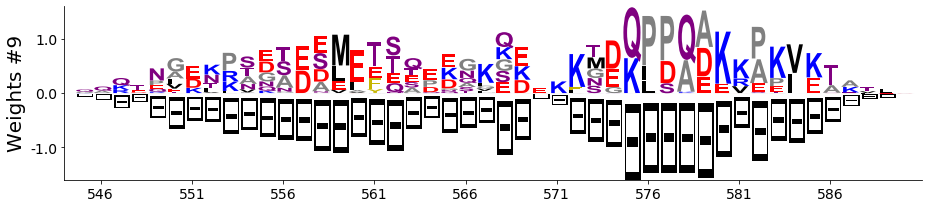

Number of sites selected: 57


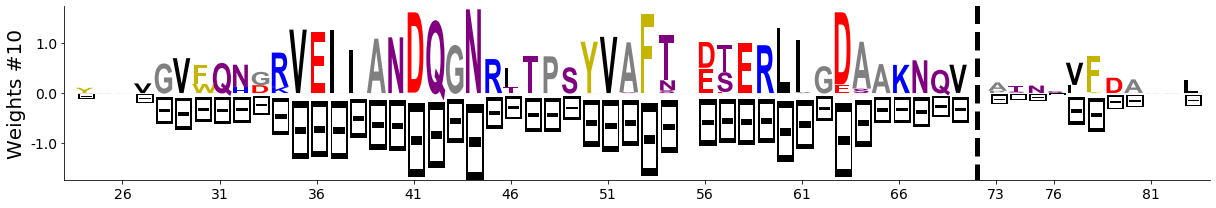

In [62]:
# if make_training:
#     interesting = [100, # short loop, NBD
#                    12, # beta-strans, SBD
#                    89, # LID-SBD interdomain
#                    160, # NBD-SBD interdomain, Allosteric-specific unit
#                    186, # Unstructured tail
#                    91, # Very short loop, NBD
#                    137, # long loop variant, NBD
#                    2, # ER-specific unit
#                    170, # Allosteric-specific unit #2
#                    88] # Dimer mode
# else:
#     interesting = [3, # short loop, NBD
#                    74, # beta-strans, SBD
#                    120, # LID-SBD interdomain
#                    52, # NBD-SBD interdomain, Allosteric-specific unit
#                    71, # Unstructured tail
#                    183, # Very short loop, NBD
#                    137, # long loop variant, NBD
#                    139, # ER-specific unit
#                    152, # Allosteric-specific unit #2
#                    88] # Dimer mode

### The seed is different from the Python2 version. Need to find manually the corresponding features in the new training...

# For features F3,F7,F9,F10 -> Please inspect manually the weights file.
# Features 3, 7, 10 -> Please inspect manually the weights file.
# Features 4 and 9 may be interchanged.


DeltaL = RBM_utils.get_hidden_unit_importance(RBM,all_data,weights=all_weights)

h = RBM.mean_hiddens(all_data)
first_target = (1 * is_dnak  + 1. * is_mitochondrial + 1. * is_chloroplastal- 1. * is_hsca - 1. * is_ER - 1. * is_nucleus_cyto)
second_target = (1 * is_hsca  + 1. * is_chloroplastal - 1. * is_non_allosteric - 1. * is_nucleus_cyto- 1. * is_ER)
third_target = 2*is_non_allosteric-1
fourth_target = 2*is_hsca-1
fifth_target = 2 * is_ER -1



interesting_features = np.zeros(10,dtype=np.int)

for target,index in zip([first_target,second_target,third_target,fourth_target,fifth_target],[0,1,3,5,7]):
    correlation = np.corrcoef(h[target!=0].T, target[np.newaxis,target!=0])[:-1,-1]
    i = np.argsort(np.abs(correlation))[-1]
    interesting_features[index]  = i
    
norm_site = np.abs(RBM.weights[:,:,:-1]).sum(-1)/np.abs(RBM.weights).sum(-1).sum(-1)[:,np.newaxis]
tail_norm = norm_site[:,625:].sum(1)
interesting_features[4] =  np.argmax(tail_norm)

p = RBM_utils.get_sparsity(RBM.weights)
gap_fraction = RBM_utils.get_norm_gaps(RBM.weights,a=1)/RBM_utils.get_norm(RBM.weights,a=1)


interesting_features[2] = np.argsort(DeltaL)[-1]

interesting_features[6] = np.argmax(-p + (gap_fraction< 0.4) ) # Not necessarily related to the paper. Show a sparse feature instead.

target = third_target
correlation = np.corrcoef(h[target!=0].T, target[np.newaxis,target!=0])[:-1,-1]
interesting_features[8] = np.argsort(np.abs(correlation))[-2]

interesting_features[9] = np.argsort(DeltaL)[-2]

import importlib;importlib.reload(sequence_logo)

fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[0]],ylabel = 'Weights #1',theta_important=0.4);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[1]],ylabel = 'Weights #2',selected = range(450,475));
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[2]],ylabel = 'Weights #3',theta_important=0.4,nrows=1);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[3]],ylabel = 'Weights #4',theta_important=0.4,nrows=1);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[4]],ylabel = 'Weights #5',theta_important=0.4,nrows=1);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[5]],ylabel = 'Weights #6',theta_important=0.4,nrows=1);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[6]],ylabel = 'Weights #7',theta_important=0.4,nrows=1);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[7]],ylabel = 'Weights #8',theta_important=0.4,nrows=1);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[8]],ylabel = 'Weights #9',theta_important=0.4,nrows=1);
fig, _ = sequence_logo.Sequence_logo_breaks(RBM.weights[interesting_features[9]],ylabel = 'Weights #10',theta_important=0.4,nrows=1);



## Visualizing hidden units: Distribution of inputs and non-linearity.
Protein sequences cluster according to the projections onto the weights.

../source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))
../utilities/plots_utils.py:89: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax2_.hist(I[:,subset[i]],normed=True,weights=weights,bins=100)


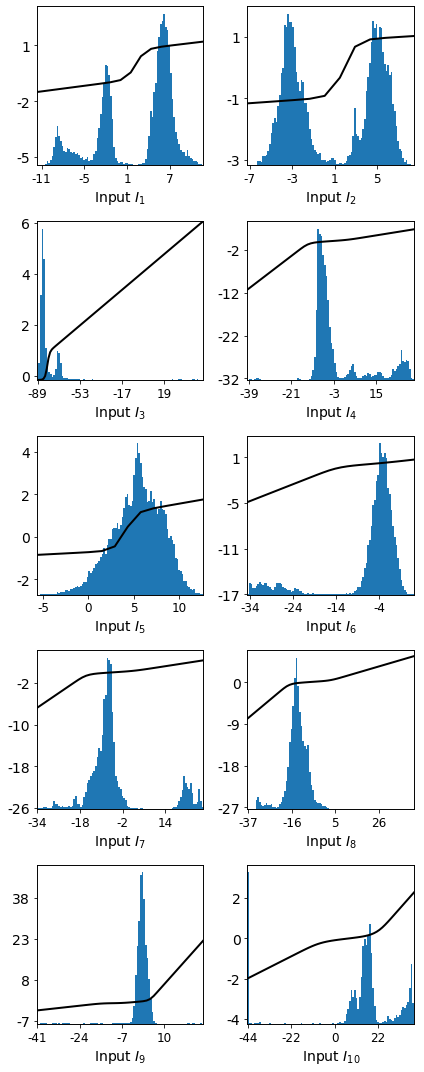

In [65]:
I = RBM.input_hiddens(all_data) # compute hidden unit input.
# Show inputs histogram and conditional means
plots_utils.plot_input_mean(RBM,I, interesting_features,ncols=2); 

## Visualizing hidden units: Phylogenic activity.
Are the features active across all, or only a portion of the phylogenic tree ? To assess this, we pick for each hidden unit the 20 sequences with highest $I_\mu$ (or lowest, depending on the sign of the non-linearity), and compute the distances between each pair. We compare to the background distribution of pairwise distances

../utilities/plots_utils.py:319: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax_.hist(all_distances,bins=RBM.n_v,normed=True,range=(0,1),color = 'gray',alpha = 0.5)
../utilities/plots_utils.py:320: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax_.hist(distance_top_features[subset[i]],bins=RBM.n_v,normed=True,range=(0,1),alpha=0.5)


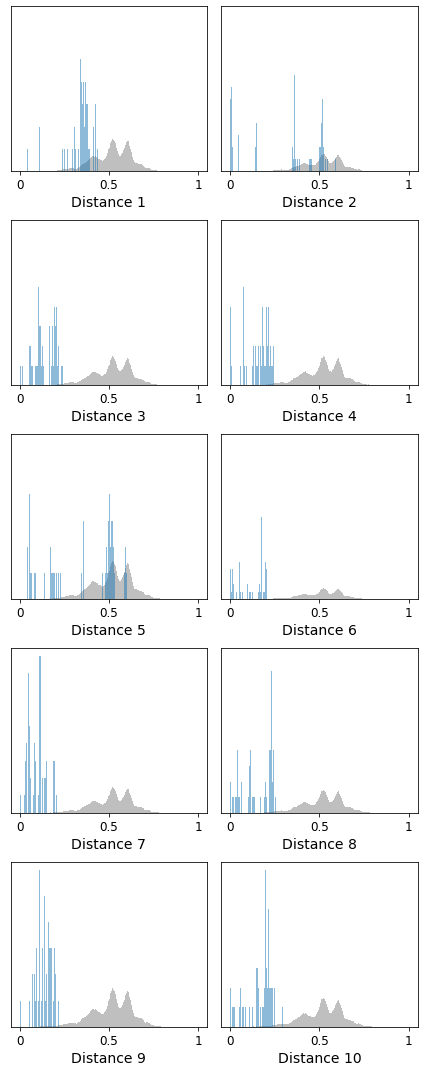

In [66]:
# Compute histogram of distances between top-activating sequences.
plots_utils.plot_top_activating_distance(RBM, I,all_data,interesting_features,ncols=2);

# Visualize all weights
Make all the previous plots, for all hidden units into a single pdf. In addition, optionally displays the weight on a structure (provide either a pdb id or path to a pdb file).
Requirements:
- With or without the structures: pdfjoin (command line utility).
- For displaying the structure:
    - the Biopython package for parsing structure files.
    - HMMER for aligning the pdb sequence to the alignment.
    - Chimera.
- Change the paths in Proteins_3D_utils.py



In [3]:
RBM = RBM_utils.loadRBM('/Users/jerometubiana/Google Drive/Scripts/PGM3/examples/RBM_Hsp70.data')

In [14]:
structure = 'ADP' #'ATP', 'ADP', False

if structure == 'ADP':
    pdb = '2kho'
    chain = None
    name = 'all_weights_Hsp70_ADP.pdf'
    turn = turn = 'turn 0,1,0 270; focus; turn 1,0,0 180; turn 0,0,1 20; focus;'
elif structure == 'ATP':
    pdb = '4jne'
    chain = 'A'
    turn = None
    name = 'all_weights_Hsp70_ATP.pdf'    
    
else:
    pdb = None
    turn = None
    name = 'all_weights_Hsp70.pdf'    
    
plots_utils.make_all_weights(RBM,all_data, weights=all_weights,
                             weights_per_page = 4,
                             rows_per_weight=4,pdb_file = pdb,
                             name = name,visualize_sector_kwargs={'chain':chain,'turn':turn},dpi=50 )

../source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


2kho is a PDB id
/Volumes/Carte_SD/PDB_files/pdb2kho.ent has 1 chains
['A']
Learning the mapping between MSA columns and PDB sequence index from the alignment...
Iteration 1: --------------IIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDGETLVGQPAKRQAVTNPQNTLFAIKRLIGRRFQDEEVQRDVSIMPFKIIA-ADNGDAWVEVKG--QKMAPPQISAEVLKKMKKTAEDYLGEPVTEAVITVPAYFNDAQRQATKDAGRIAGLEVKRIINEPTAAALAYGLDKG-TGNRTIAVYDLGGGTFDISIIEIDevdgEKTFEVLATNGDTHLGGEDFDSRLINYLVEEFKKDQGIDLRNDPLAMQRLKEAAEKAKIELSSAQQTDVNLPYITADATGPKHMNIKVTRAKLESLVEDLVNRSIEPLKVALQDAGLSVSDIDDVILVGGQTRMPMVQKKVAEFF-GKEPRKDVNPDEAVAIGAAVQGGVLTG----DVKDVLLLDVTPLSLGIETMGGVMTTLIAKNTTIPTKHSQVFSTAEDNQSAVTIHVLQGERKRAADNKSLGQFNLDGINPAPRGMPQIEVTFDIDADGILHVSAKDKNSGKEQKITIKASSG-LNEDEIQKMVRDAEANAEADRKFDELVQTRNQGDHLLHSTRKQVEE--AGDKLPADDKTAIESALTALETALKG---EDKAAIEAKMQELAQVSQKLME-----------------------------------------------------iaq,
675
Iteration 1, fraction of sites mapped on the structure: 0.88
Iteration 2: --------------IIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDGETLVGQ

../utilities/plots_utils.py:92: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax2_.hist(I[:,subset[i]],normed=True,weights=weights,bins=100)
../utilities/plots_utils.py:320: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax_.hist(all_distances,bins=RBM.n_v,normed=True,range=(0,1),color = 'gray',alpha = 0.5)
../utilities/plots_utils.py:321: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax_.hist(distance_top_features[subset[i]],bins=RBM.n_v,normed=True,range=(0,1),alpha=0.5)


Make all weights: Done.


'done'

# Identification of Functional Subgroups 


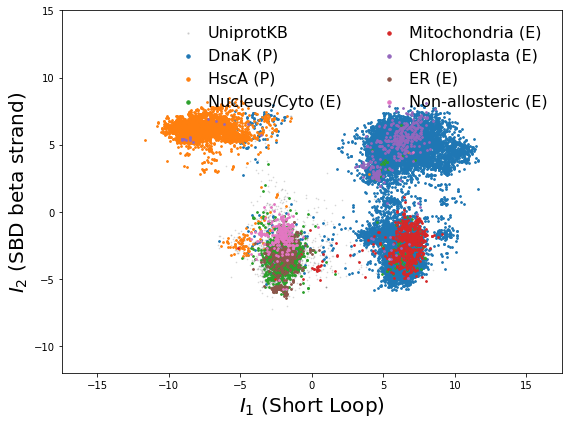

In [80]:
## Scatter plot: [short/long loop] vs [SBD beta strand]
I_background = I

I_test = [I_background[category] for category in 
         [is_dnak,is_hsca,is_nucleus_cyto,is_mitochondrial,is_chloroplastal,is_ER,is_non_allosteric]]


class_names = ['DnaK (P)','HscA (P)','Nucleus/Cyto (E)', 'Mitochondria (E)',
                'Chloroplasta (E)', 'ER (E)','Non-allosteric (E)']




axis_labels1 = [r'$I_{%s}$'%(i+1) for i in range(2)]
axis_labels2 = ['Short Loop', 'SBD beta strand']
axis_labels = [[x + ' (' + y +')' for x,y in zip(axis_labels1,axis_labels2)]]



fig = plots_utils.plot_input_classes_scatter([[interesting_features[0],interesting_features[1]]],I_background, I_test,  class_names=class_names, axis_labels=axis_labels,
              figsize=[8,6], fontsize=20,ncols_legend=2,xlim=None,ylim=[[-12,15]],background_name='UniprotKB');



../utilities/plots_utils.py:174: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax2_.hist(I_test[k][:,subset[i]],color=colors[k],normed=True, histtype='step',label=label_names[k],bins=nbins[k])


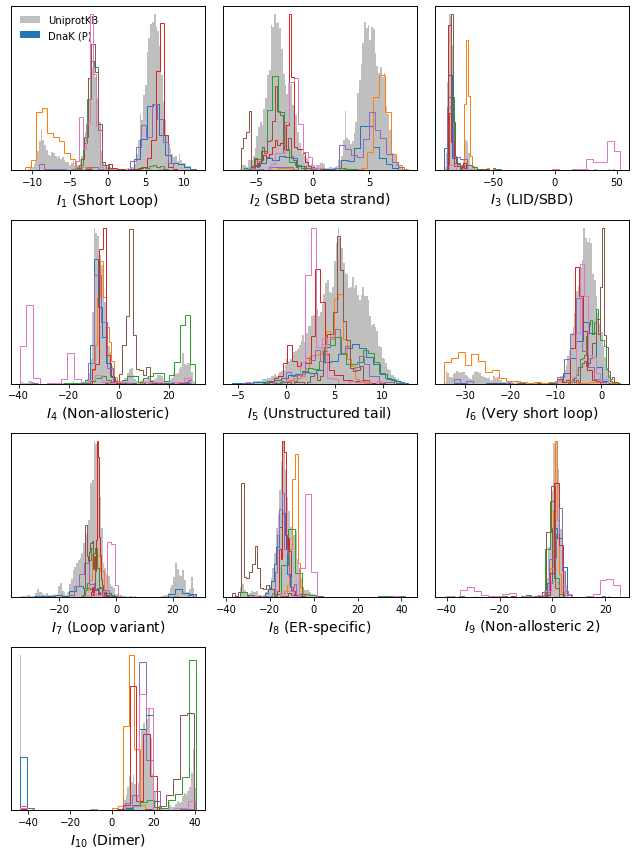

In [96]:
## All input histograms
ncols = 3

xlabels1 = [r'$I_{%s}$'%(i+1) for i in range(10)]
xlabels2 = ['Short Loop', 'SBD beta strand', 'LID/SBD','Non-allosteric','Unstructured tail',
           'Very short loop','Loop variant','ER-specific','Non-allosteric 2', 'Dimer']

xlabels = [x + ' (' + y +')' for x,y in zip(xlabels1,xlabels2)]


fig = plots_utils.plot_input_classes(interesting_features,I_background,I_test,
                                     class_names=class_names,nbins=25,background_name='UniprotKB',
                                     ncols=3,xlabels=xlabels);



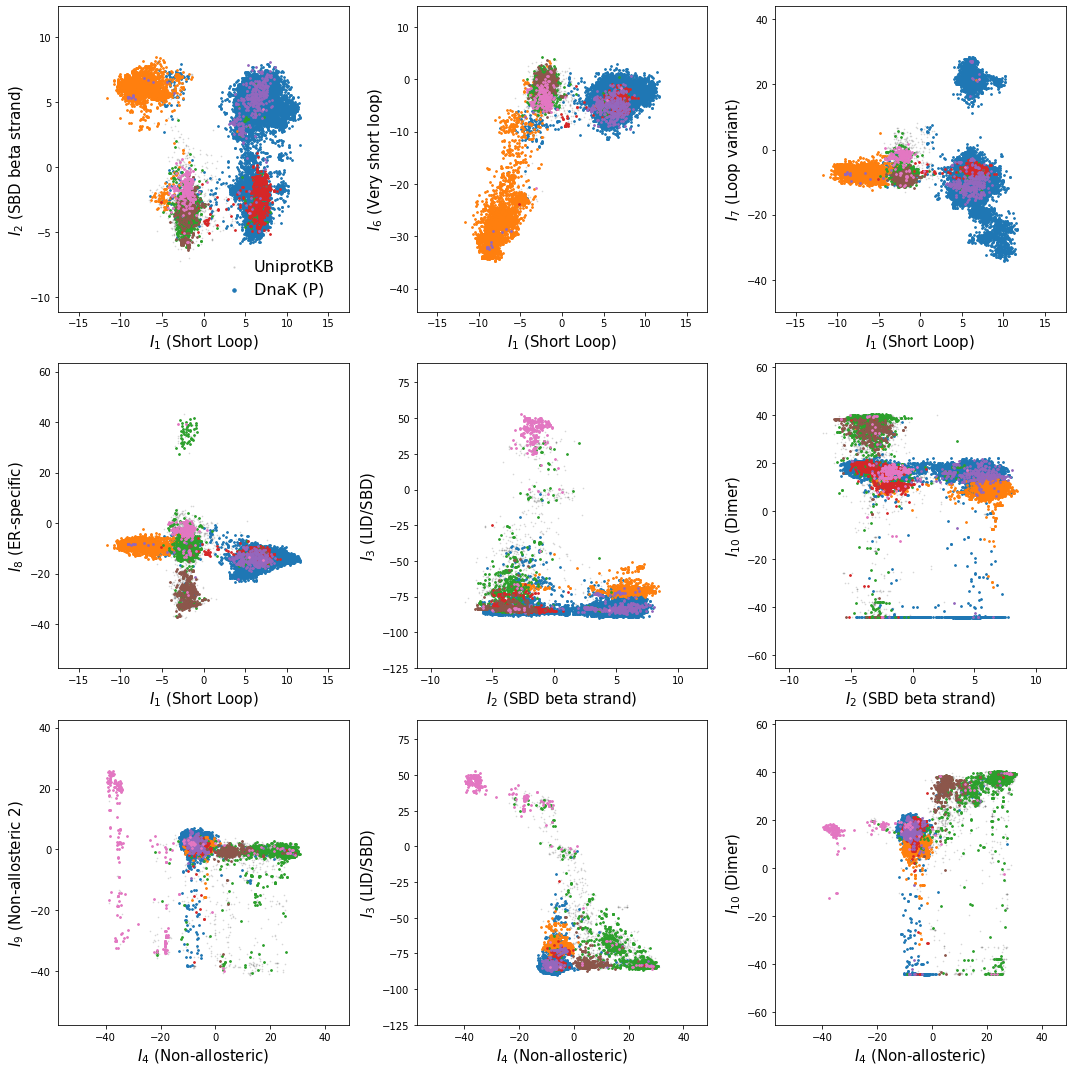

In [85]:
## Some input scatter plots

liste_interestings = [(0,1),
                     (0,5),
                     (0,6),
                     (0,7),
                     (1,2),
                     (1,9),
                     (3,8),
                     (3,2),
                     (3,9)]

interestings = [ (interesting_features[linteresting[0]],interesting_features[linteresting[1]]) for linteresting in liste_interestings ]


xlabels1 = [r'$I_{%s}$'%(i+1) for i in range(10)]
xlabels2 = ['Short Loop', 'SBD beta strand', 'LID/SBD','Non-allosteric','Unstructured tail',
           'Very short loop','Loop variant','ER-specific','Non-allosteric 2', 'Dimer']

xlabels = [x + ' (' + y +')' for x,y in zip(xlabels1,xlabels2)]

axis_labels = [(xlabels[linteresting[0]],xlabels[linteresting[1]]) for linteresting in liste_interestings]


fig = plots_utils.plot_input_classes_scatter(interestings,I_background, I_test,  class_names=class_names,
              figsize=5, fontsize=15,ncols=3,background_name='UniprotKB',
              axis_labels = axis_labels);


../utilities/plots_utils.py:171: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  for k in range(n_class):
../utilities/plots_utils.py:176: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax_.set_xlabel(xlabels[i],fontsize=14)


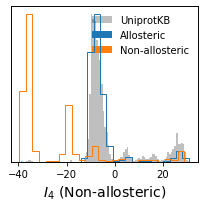

In [75]:
# Allosteric vs non-allosteric (Input I4)
labels_classes = np.asarray(is_non_allosteric*1,dtype='int')
labels_classes = labels_classes[classified]
labels_names = ['Allosteric','Non-allosteric']
ncols = 1
xlabels1 = [r'$I_{%s}$'%(i+1) for i in range(3,4)]
xlabels2 = ['Non-allosteric']

xlabels = [x + ' (' + y +')' for x,y in zip(xlabels1,xlabels2)]

I_test = I_background[classified]

fig = plots_utils.plot_input_classes([interesting_features[3]],I_background,I_test,labels_classes,label_names=labels_names,nbins=25,label_background='UniprotKB',ncols=1,xlabels=xlabels);




# A null model for the tail: Check enrichment of the tail in hydrophilic or hydrophobic amino-acids.
Do we find sequences with an hydrophilic-rich (resp. tiny-rich) unstructured tail, or they are expected from an independent model with variable tail length ?
We compare observed statistics with a Monte Carlo simulation with null model...

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


/specific/netapp5_2/iscb/wolfson/jeromet/v_env/p36_tf/lib/python3.6/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/specific/netapp5_2/iscb/wolfson/jeromet/v_env/p36_tf/lib/python3.6/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/specific/netapp5_2/iscb/wolfson/jeromet/v_env/p36_tf/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/specific/netapp5_2/iscb/wolfson/jeromet/v_env/p36_tf/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
/sp

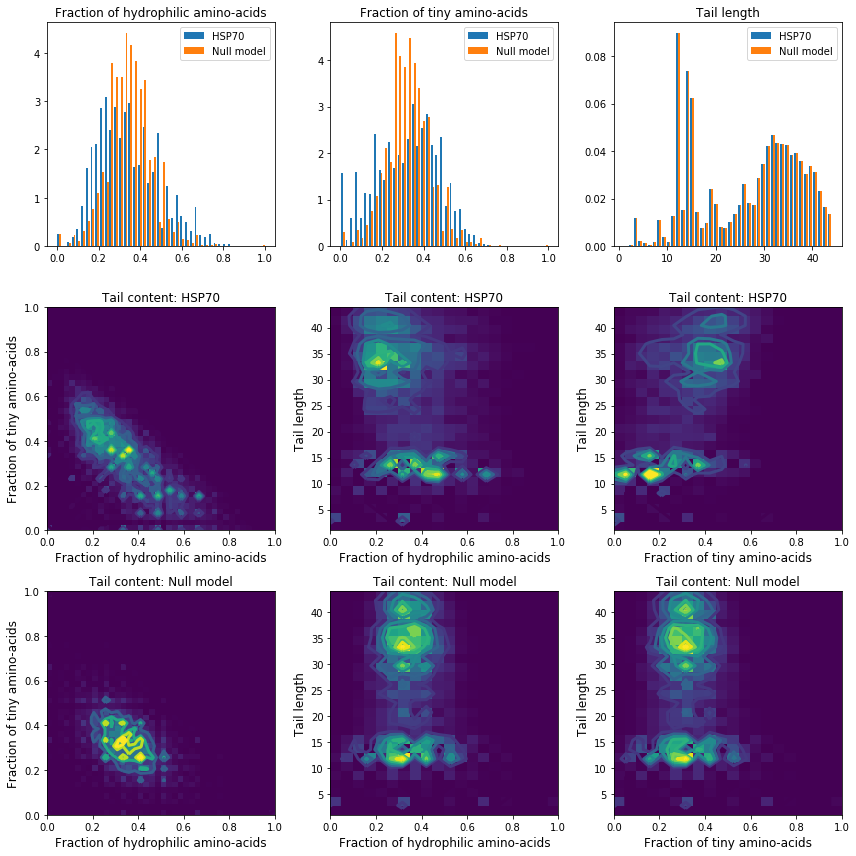

In [71]:
from float_precision import curr_float,curr_int

surface_sites = np.nonzero(np.abs(RBM.weights[interesting_features[4]]).sum(-1) > 0.5)[0]
num_sites = len(surface_sites)

seq_num_sites = (all_data[:,surface_sites] != 20).sum(1)
seq_num_tiny =  ((all_data[:,surface_sites] == Proteins_utils.aadict['A']) | (all_data[:,surface_sites] == Proteins_utils.aadict['G']) ).sum(-1)

seq_num_hydrophilic =  ((all_data[:,surface_sites] == Proteins_utils.aadict['E']) \
| (all_data[:,surface_sites] == Proteins_utils.aadict['K']) | (all_data[:,surface_sites] == Proteins_utils.aadict['R'])\
| (all_data[:,surface_sites] == Proteins_utils.aadict['S']) | (all_data[:,surface_sites] == Proteins_utils.aadict['N'])\
| (all_data[:,surface_sites] == Proteins_utils.aadict['T']) ).sum(-1)




seq_frac_hydrophilic = seq_num_hydrophilic/(1e-10+seq_num_sites)
seq_frac_tiny = seq_num_tiny/(1e-10+seq_num_sites)

lengths = np.arange(1,num_sites+1)
probas = np.array([(seq_num_sites == length).sum() for length in lengths])
probas= 1.0 * probas/probas.sum()



mu_hydrophilic = (seq_frac_hydrophilic ).mean()
mu_tiny = (seq_frac_tiny ).mean()

MC = 50000

all_mus = []
all_weights = []
all_lengths = []
for length,proba in zip(lengths,probas): # Null model with
    print(length)
    for _ in range(MC):
        rng = np.random.rand(length)
        content = np.zeros([length,1],dtype=curr_int)
        content[rng< mu_hydrophilic] = 0
        content[(mu_hydrophilic <= rng) & (rng< mu_tiny +mu_hydrophilic)] = 1
        content[rng>mu_hydrophilic+mu_tiny] = 2
        mu = utilities.average(content,c=3)[0,:2]
        all_mus.append(mu)
        all_weights.append(proba)
        all_lengths.append(length)

all_mus = np.array(all_mus)
all_weights = np.array(all_weights)


fontsize = 12
fontsize2 = 10
vmax = 20
vmax2 = 0.25

fig, ax = plt.subplots(3,3)
fig.set_figheight(12)
fig.set_figwidth(12)


ax[0,0].hist( [seq_frac_hydrophilic ,all_mus[:,0]],weights=[np.ones(all_data.shape[0]),all_weights],bins=num_sites,normed=True ); 
ax[0,0].legend(['HSP70','Null model'],fontsize=fontsize2);
ax[0,0].set_title('Fraction of hydrophilic amino-acids',fontsize=fontsize);

ax[0,1].hist( [seq_frac_tiny, all_mus[:,1]],weights=[np.ones(all_data.shape[0]),all_weights],bins=num_sites,normed=True );
ax[0,1].legend(['HSP70','Null model'],fontsize=fontsize2);
ax[0,1].set_title('Fraction of tiny amino-acids',fontsize=fontsize);


ax[0,2].hist( [seq_num_sites, all_lengths],weights=[np.ones(all_data.shape[0]),all_weights],bins=num_sites,normed=True );
ax[0,2].legend(['HSP70','Null model'],fontsize=fontsize2);
ax[0,2].set_title('Tail length',fontsize=fontsize);



counts,xbins,ybins,image = ax[1,0].hist2d(seq_frac_hydrophilic,seq_frac_tiny,bins=40,normed=True, range=[(0,1),(0,1)]);
ax[1,0].contour(counts.T,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,vmin=0,vmax=vmax);
ax[1,0].set_xlim([0,1])
ax[1,0].set_ylim([0,1])
ax[1,0].set_xlabel('Fraction of hydrophilic amino-acids',fontsize=fontsize)
ax[1,0].set_ylabel('Fraction of tiny amino-acids',fontsize=fontsize)
ax[1,0].set_title('Tail content: HSP70')


counts,xbins,ybins,image = ax[1,1].hist2d(seq_frac_hydrophilic,seq_num_sites,bins=[20,25],normed=True, range=[(0,1),(1,num_sites)]);
ax[1,1].contour(counts.T,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,vmin=0,vmax=vmax2);
ax[1,1].set_xlim([0,1])
ax[1,1].set_ylim([1,num_sites])
ax[1,1].set_xlabel('Fraction of hydrophilic amino-acids',fontsize=fontsize)
ax[1,1].set_ylabel('Tail length',fontsize=fontsize)
ax[1,1].set_title('Tail content: HSP70')


counts,xbins,ybins,image = ax[1,2].hist2d(seq_frac_tiny,seq_num_sites,bins=[20,25],normed=True, range=[(0,1),(1,num_sites)]);
ax[1,2].contour(counts.T,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,vmin=0,vmax=vmax2);
ax[1,2].set_xlim([0,1])
ax[1,2].set_ylim([1,num_sites])
ax[1,2].set_xlabel('Fraction of tiny amino-acids',fontsize=fontsize)
ax[1,2].set_ylabel('Tail length',fontsize=fontsize)
ax[1,2].set_title('Tail content: HSP70')


counts,xbins,ybins,image = ax[2,0].hist2d(all_mus[:,0],all_mus[:,1],weights=all_weights,bins=40,normed=True, range=[(0,1),(0,1)]);
ax[2,0].contour(counts.T,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,vmin=0,vmax=vmax);
ax[2,0].set_xlim([0,1])
ax[2,0].set_ylim([0,1])
ax[2,0].set_xlabel('Fraction of hydrophilic amino-acids',fontsize=fontsize)
ax[2,0].set_ylabel('Fraction of tiny amino-acids',fontsize=fontsize)
ax[2,0].set_title('Tail content: Null model')



counts,xbins,ybins,image = ax[2,1].hist2d(all_mus[:,0],all_lengths,weights=all_weights,bins=[20,25],normed=True, range=[(0,1),(1,num_sites)]);
ax[2,1].contour(counts.T,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,vmin=0,vmax=vmax2);
ax[2,1].set_ylim([1,num_sites])
ax[2,1].set_xlim([0,1])
ax[2,1].set_ylabel('Tail length',fontsize=fontsize)
ax[2,1].set_xlabel('Fraction of hydrophilic amino-acids',fontsize=fontsize)
ax[2,1].set_title('Tail content: Null model')

counts,xbins,ybins,image = ax[2,2].hist2d(all_mus[:,1],all_lengths,weights=all_weights,bins=[20,25],normed=True, range=[(0,1),(1,num_sites)]);
ax[2,2].contour(counts.T,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,vmin=0,vmax=vmax2);
ax[2,2].set_ylim([1,num_sites])
ax[2,2].set_xlim([0,1])
ax[2,2].set_ylabel('Tail length',fontsize=fontsize)
ax[2,2].set_xlabel('Fraction of tiny amino-acids',fontsize=fontsize)
ax[2,2].set_title('Tail content: Null model')



plt.tight_layout()